In [ ]:
##imports
import importlib
from tensorflow.keras.models import load_model
from collections import Counter
import seaborn as sns
import codecs  
import random  
import numpy as np
from sklearn.model_selection import train_test_split  
from keras.layers import * 
from tensorflow.keras.models import Model  
import keras
from keras.layers import Input 
from tensorflow.keras.utils import plot_model
import evaluation
import matplotlib.pyplot as plt
import pandas as pd
import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer  
import embedding_models
import create_model
from tensorflow.keras.callbacks import EarlyStopping
from tabulate import tabulate
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


## Task 0: Read the file

In [5]:

# Load Portuguese sentences  
with codecs.open('data/europarl-v7.pt-en.pt', 'r', encoding='utf-8') as f:  
    portuguese_sentences = f.readlines()  

# Load English sentences  
with codecs.open('data/europarl-v7.pt-en.en', 'r', encoding='utf-8') as f:  
    english_sentences = f.readlines()  


## Task 1: Data exploration (10%) 
For this task you should extract some insights (i.e., some statistics and graphs) from the provided data. 
It could be the length differences between two languages and the number of sentences in the whole 
corpus. Don’t limit yourself into these examples and try to find more insights in the data. Please 
highlight some of the most important findings in your report.  
Moreover,  since  the  dataset  is too  large,  randomly select  10%  of  data (data sampling)  to  train your 
models on in the next steps. You can use a smaller sample in case 10% of the data is still too big to be 
trained in your local machine. 
Hint: if you faced codec errors in reading files, the “codecs” library could be used. 

In [7]:
number_of_sentences = len(portuguese_sentences)
print("Number of sentences: ", number_of_sentences)

Number of sentences:  1960407


### General statistics

In [34]:
eng_lengths = [len(sentence.split()) for sentence in english_sentences]
pt_lengths = [len(sentence.split()) for sentence in portuguese_sentences]
def count_unique_words(sentences):  
    tokenizer = Tokenizer()  
    tokenizer.fit_on_texts(sentences)  
    word_index = tokenizer.word_index  
    return len(word_index)  
def count_unique_characters(sentences):
    combined_text = ''.join(sentences)
    unique_characters = set(combined_text)
    return len(unique_characters)  
def count_non_alphabetical_characters(sentences):
    combined_text = ''.join(sentences)
    non_alpha_characters = re.findall(r'[^a-zA-Z\s]', combined_text)
    character_freq = Counter(non_alpha_characters)
    return character_freq  
  
  
unique_english_words = count_unique_words(english_sentences)  
unique_portuguese_words = count_unique_words(portuguese_sentences)  
unique_characters_english = count_unique_characters(english_sentences)
unique_characters_portuguese = count_unique_characters(portuguese_sentences)
non_alpha_freq_english = count_non_alphabetical_characters(english_sentences)
non_alpha_freq_portuguese = count_non_alphabetical_characters(portuguese_sentences)

total_non_alpha_english = len(non_alpha_freq_english)
total_non_alpha_portuguese = len(non_alpha_freq_portuguese)

en_max_len = np.max(eng_lengths)
en_avg_len = np.mean(eng_lengths)
en_median_len = np.median(eng_lengths)
en_std_len = np.std(eng_lengths)
en_min_len = np.min(eng_lengths)
en_num_words = np.sum(eng_lengths)

pt_max_len = np.max(pt_lengths)
pt_avg_len = np.mean(pt_lengths)
pt_median_len = np.median(pt_lengths)
pt_std_len = np.std(pt_lengths)
pt_min_len = np.min(pt_lengths)
pt_num_words = np.sum(pt_lengths)

print('English Sentence Lengths:')
print('Max:', en_max_len)
print('Min:', en_min_len)
print('Average:', en_avg_len)
print('Median:', en_median_len)
print('Standard Deviation:', en_std_len)
print('Total Words:', en_num_words)
print(f"Number of unique English words: {unique_english_words}")  
print(f"Number of unique characters in English: {unique_characters_english}")
print(f"Total number of unique non-alphabetical characters in English: {total_non_alpha_english}")

print('Portuguese Sentence Lengths:')
print('Max:', pt_max_len)
print('Min:', pt_min_len)
print('Average:', pt_avg_len)
print('Median:', pt_median_len)
print('Standard Deviation:', pt_std_len)
print('Total Words:', pt_num_words)
print(f"Number of unique Portuguese words: {unique_portuguese_words}")  
print(f"Number of unique characters in Portuguese: {unique_characters_portuguese}")
print(f"Total number of unique non-alphabetical characters in Portuguese: {total_non_alpha_portuguese}")


English Sentence Lengths:
Max: 668
Min: 0
Average: 25.139747001515502
Median: 22.0
Standard Deviation: 15.206363493096843
Total Words: 49284136
Number of unique English words: 118793
Number of unique characters in English: 312
Total number of unique non-alphabetical characters in English: 257
Portuguese Sentence Lengths:
Max: 636
Min: 0
Average: 25.473179293891523
Median: 23.0
Standard Deviation: 15.66722395305869
Total Words: 49937799
Number of unique Portuguese words: 162175
Number of unique characters in Portuguese: 328
Total number of unique non-alphabetical characters in Portuguese: 273


### Distribution of Sentence Lengths

English Sentence Lengths:
Max: 668
Min: 0
Average: 25.139747001515502
Median: 22.0
Standard Deviation: 15.206363493096843
Portuguese Sentence Lengths:
Max: 636
Min: 0
Average: 25.473179293891523
Median: 23.0
Standard Deviation: 15.66722395305869


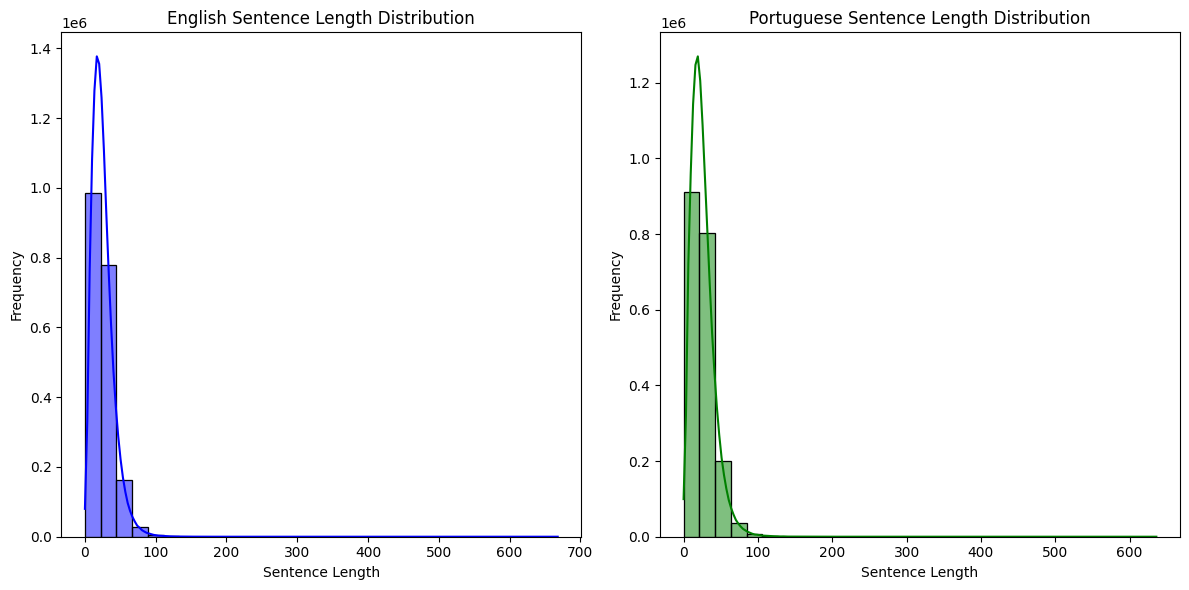

In [ ]:

plt.figure(figsize=(12, 6))

# Histogram for English sentences
plt.subplot(1, 2, 1)
sns.histplot(eng_lengths, bins=30, kde=True, color='blue')
plt.title('English Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

# Histogram for Portuguese sentences
plt.subplot(1, 2, 2)
sns.histplot(pt_lengths, bins=30, kde=True, color='green')
plt.title('Portuguese Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Number of Sentences per line

In [30]:

def count_sentences(line, language='english'):
    # Tokenize the line into sentences
    sentences = sent_tokenize(line, language=language)
    return len(sentences)

def max_sentences_per_line(sentences, language='english'):
    max_sentences = 0
    
    for line in sentences:
        sentence_count = count_sentences(line, language=language)
        if sentence_count > max_sentences:
            max_sentences = sentence_count
    
    return max_sentences

# Get the maximum number of sentences per line for both datasets
max_sentences_english = max_sentences_per_line(english_sentences, language='english')
max_sentences_portuguese = max_sentences_per_line(portuguese_sentences, language='portuguese')

print(f"Maximum number of sentences per line in English dataset: {max_sentences_english}")
print(f"Maximum number of sentences per line in Portuguese dataset: {max_sentences_portuguese}")


Maximum number of sentences per line in English dataset: 6
Maximum number of sentences per line in Portuguese dataset: 8


### Top 10 most common words

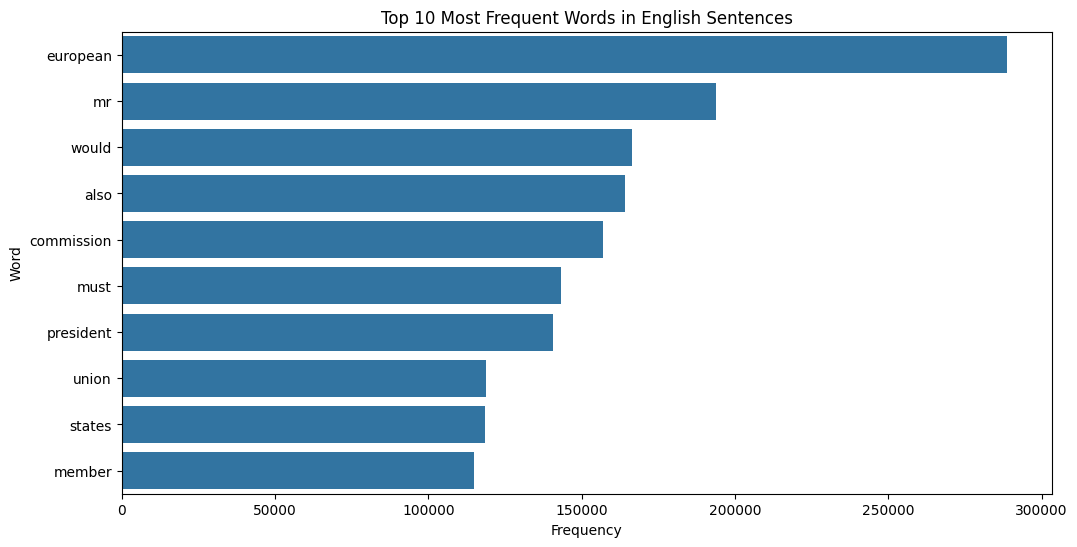

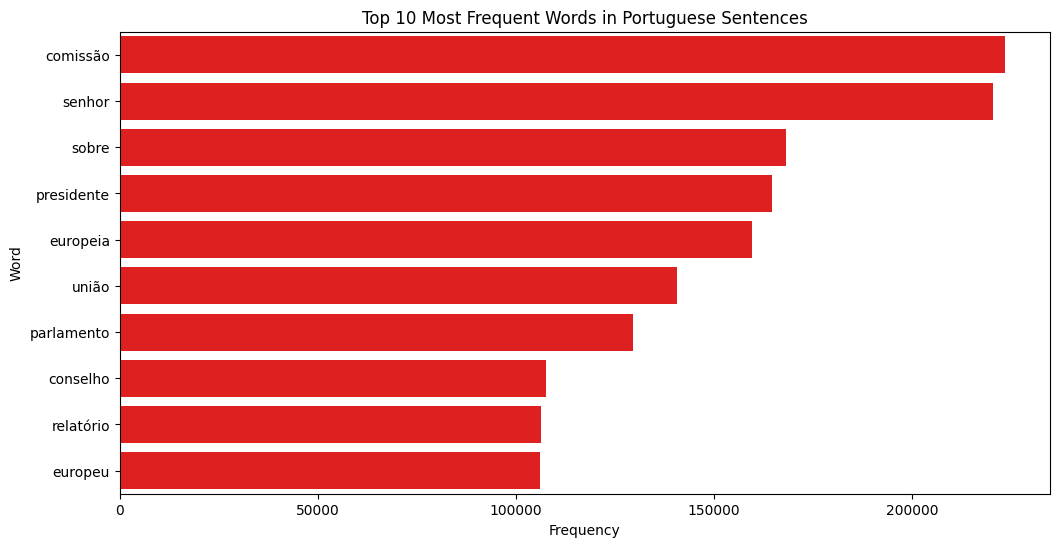

In [32]:
# Load English stopwords 
stop_words_eng = set(stopwords.words('english'))
stop_words_pt = set(stopwords.words('portuguese'))

def preprocess_text(text, language='english'): #preliminary text processing for statistics
    text = text.lower()
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'[^\w\s]', '', text)  
    tokens = word_tokenize(text, language=language)
    stop_words = stop_words_pt if language == 'portuguese' else stop_words_eng
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def compute_word_frequencies(sentences, language='english'):
    all_tokens = []
    for sentence in sentences:
        all_tokens.extend(preprocess_text(sentence, language))
    return Counter(all_tokens)

def get_most_common_words(word_freq, top_n=10):
    return word_freq.most_common(top_n)

# Compute word frequencies
word_freq_english = compute_word_frequencies(english_sentences)
# Get the top 10 most common words
most_common_words_english = get_most_common_words(word_freq_english, top_n=10)
freq_df_english = pd.DataFrame(most_common_words_english, columns=['Word', 'Frequency'])

word_freq_portuguese = compute_word_frequencies(portuguese_sentences, language='portuguese')
most_common_words_portuguese = get_most_common_words(word_freq_portuguese, top_n=10)
freq_df_portuguese = pd.DataFrame(most_common_words_portuguese, columns=['Word', 'Frequency'])

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=freq_df_english)
plt.title('Top 10 Most Frequent Words in English Sentences')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=freq_df_portuguese, color='red')
plt.title('Top 10 Most Frequent Words in Portuguese Sentences')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## Task 2: Pre-processing (15%) 
In this task, first, apply all the necessary pre-processing steps that you think they would help to better 
prepare your data for the next steps.  You don’t have to apply all the pre-processing tasks which are 
covered in the course. Regarding the report, you should briefly mention it in your report that why you 
decided to apply the chosen pre-processing steps (and why not the others).  
Among all the pre-processing tasks, the following are recommended: 
● lowercase the text 
● strip empty lines and their correspondences 
● remove lines with XML-Tags (starting with "<") 


#### Select random data sample

In [86]:
# random sampling of 10% of the data
sample_size = int(0.1 * len(portuguese_sentences))  
indices = random.sample(range(len(portuguese_sentences)), sample_size)  
sampled_portuguese_sentences = [portuguese_sentences[i] for i in indices]  
sampled_english_sentences = [english_sentences[i] for i in indices]  


#### Apply pre-processing steps

In [87]:
preprocessed_english, preprocessed_portuguese = preprocessing.apply_preprocessing_pipeline(sampled_english_sentences, sampled_portuguese_sentences)  


In [88]:

# Save the preprocessed data   
with codecs.open('data/preprocessed_english.en', 'w', encoding='utf-8') as f:  
    for sentence in preprocessed_english:  
        f.write(sentence + '\n')  
  
with codecs.open('data/preprocessed_portuguese.pt', 'w', encoding='utf-8') as f:  
    for sentence in preprocessed_portuguese:  
        f.write(sentence + '\n')  

## Task 3: Neural Machine Translation (45%) 
In  this  task  you  should  do  the  following  sub-tasks.  Choose  two  evaluation  metrics  and  report  your 
results using these two metrics. 
- Split data into train, validation and test sets. Use 20% of data as the test set. 
- Develop an RNN based  sequence to sequence model (encoder-decoder) to translate English 
input into Portuguese text. 
    - In your report describe your reasons for choosing the architecture that you are using 
for the task 
    - Track the impact of different embedding models (e.g., Glove, Word2Vec and ...) on 
the performance of your model. 
    - Interpret  the  results  of  your  model  in  the  report. Does the  length of  text  impact  on 
the  performance  of  the  model?  What  characteristic  of  sentences  led  to  better 
translation by the model? 
- Change your input and target languages (Translate from Portuguese to English) and train your 
mode again 
    - Compare the results in this step with the results from the previous step where English 
was the input language. 
- Develop a character-based model that train to translate characters into the target language. 
Compare  the  results  by  this  model  with  the  achieved  results  from  the  word-based  models 
before. 
Please report all the achieved results with either models in your report document. Moreover, describe 
the hyper-parameters of your neural network model in the report.



### Load preproccessed data from file

In [4]:

def load_data(english_file, portuguese_file, path = "data/"):  
    with codecs.open(path+english_file, 'r', encoding='utf-8') as f:  
        english_sentences = [line.strip() for line in f.readlines()] 
    with codecs.open(path+portuguese_file, 'r', encoding='utf-8') as f:  
        portuguese_sentences = [line.strip() for line in f.readlines()]
    return english_sentences, portuguese_sentences
  
english_sentences, portuguese_sentences = load_data('preprocessed_english.en', 'preprocessed_portuguese.pt')  

### Split data into train, validation and test sets

In [33]:
# due to computational constraints, we further reduce the size of our dataset and only use the first 100,000 sentences of our preprocessed data
train_eng, test_eng, train_pt, test_pt = train_test_split(english_sentences[:100000], portuguese_sentences[:100000], test_size=0.2, random_state=42)  # 20% of the data is used for testing


In [22]:
#writing the train and test data to files for later use
with codecs.open('data/train_eng', 'w', encoding='utf-8') as f:  
    for sentence in train_eng:  
        f.write(sentence + '\n')

with codecs.open('data/test_eng', 'w', encoding='utf-8') as f:
    for sentence in test_eng:
        f.write(sentence + '\n')

with codecs.open('data/train_pt', 'w', encoding='utf-8') as f:
    for sentence in train_pt:
        f.write(sentence + '\n')

with codecs.open('data/test_pt', 'w', encoding='utf-8') as f:
    for sentence in test_pt:
        f.write(sentence + '\n')   

#### Prepare Decoder Data

In [117]:
train_decoder_inputs = ['<start> ' + text for text in train_pt]
test_decoder_inputs = ['<start> ' + text for text in test_pt]

train_decoder_targets = [text + ' <end>' for text in train_pt]
test_decoder_targets = [text + ' <end>' for text in test_pt]

### Tokenize and pad the data  

In [118]:
# Calculate the 90th percentile of sentence lengths to determine the maximum length for padding and truncation
eng_lengths = [len(sentence.split()) for sentence in train_eng]
pt_lengths = [len(sentence.split()) for sentence in train_pt]

percentile_90_eng = np.percentile(eng_lengths, 90)
percentile_90_pt = np.percentile(pt_lengths, 90)

print(f"90th percentile sentence length for English: {percentile_90_eng}")
print(f"90th percentile sentence length for Portuguese: {percentile_90_pt}")

num_eng_below_90th = sum(length <= percentile_90_eng for length in eng_lengths)
num_pt_below_90th = sum(length <= percentile_90_pt for length in pt_lengths)

total_eng_sentences = len(eng_lengths)
total_pt_sentences = len(pt_lengths)

print(f"Number of English sentences at or below 90th percentile: {num_eng_below_90th}")
print(f"Total number of English sentences: {total_eng_sentences}")

print(f"Number of Portuguese sentences at or below 90th percentile: {num_pt_below_90th}")
print(f"Total number of Portuguese sentences: {total_pt_sentences}")

pt_max_len = int(percentile_90_pt)
en_max_len = int(percentile_90_eng)

90th percentile sentence length for English: 44.0
90th percentile sentence length for Portuguese: 45.0
Number of English sentences at or below 90th percentile: 72227
Total number of English sentences: 80000
Number of Portuguese sentences at or below 90th percentile: 72307
Total number of Portuguese sentences: 80000


In [119]:
#train tokenizer on training data
train_eng_seq, eng_tokenizer = preprocessing.tokenize(train_eng)  
train_pt_seq_input, pt_tokenizer = preprocessing.tokenize(train_decoder_inputs, decode=True)  
train_pt_seq_target,_ = preprocessing.tokenize(train_decoder_targets,tokenizer= pt_tokenizer)

#apply the tokenizer to the test and validation data
test_eng_seq,_ = preprocessing.tokenize(test_eng,tokenizer= eng_tokenizer)
test_pt_seq_input,_  = preprocessing.tokenize(test_decoder_inputs,tokenizer= pt_tokenizer)
test_pt_seq_target,_  = preprocessing.tokenize(test_decoder_targets, tokenizer= pt_tokenizer)


#apply padding to the sequences
train_eng_seq = preprocessing.pad(train_eng_seq,en_max_len)
train_pt_seq_input = preprocessing.pad(train_pt_seq_input,pt_max_len)
train_pt_seq_target  = preprocessing.pad(train_pt_seq_target,pt_max_len)

test_eng_seq = preprocessing.pad(test_eng_seq, en_max_len)
test_pt_seq_input = preprocessing.pad(test_pt_seq_input, pt_max_len)
test_pt_seq_target  = preprocessing.pad(test_pt_seq_target, pt_max_len)


#format (number of sentences, length of the longest sentence)
train_eng_seq.shape, train_pt_seq_input.shape, test_eng_seq.shape, test_pt_seq_input.shape

((80000, 44), (80000, 45), (20000, 44), (20000, 45))

In [120]:
en_vocab_size = len(eng_tokenizer.word_index) 
print('English Vocabulary Size: %d' % en_vocab_size)
print('English Max Length: %d' % (en_max_len))

pt_vocab_size = len(pt_tokenizer.word_index) 
print('Portuguese Vocabulary Size: %d' % pt_vocab_size)
print('Portuguese Max Length: %d' % (pt_max_len))


English Vocabulary Size: 30318
English Max Length: 44
Portuguese Vocabulary Size: 46138
Portuguese Max Length: 45


### Prepare the embedding matrix for encoder and decoder

In [127]:
# GloVe embeddings
glove_embeddings_index = embedding_models.load_glove_embeddings()
embedding_matrix_eng = embedding_models.apply_embedding_matrix(glove_embeddings_index, eng_tokenizer, embedding_dim=100)   #GloVe.6B.100d.txt has 100-dimensional embeddings 
glove_embeddings_index = embedding_models.load_glove_embeddings(language="portuguese")
embedding_matrix_pt = embedding_models.apply_embedding_matrix(glove_embeddings_index, pt_tokenizer, embedding_dim=100)  

embedding_matrix_eng.shape, embedding_matrix_pt.shape#(vocab in source, embedding dimension)

((30319, 100), (46139, 100))

In [65]:
# Word2Vec embeddings
word2vec_embeddings_index = embedding_models.load_word2vec_embeddings()
embedding_matrix_eng = embedding_models.apply_embedding_matrix(word2vec_embeddings_index, eng_tokenizer, embedding_dim=100)
word2vec_embeddings_index = embedding_models.load_word2vec_embeddings(language="portuguese")
embedding_matrix_pt = embedding_models.apply_embedding_matrix(word2vec_embeddings_index, pt_tokenizer, embedding_dim=100)

embedding_matrix_eng.shape, embedding_matrix_pt.shape#(vocab in source, embedding dimension)

((30319, 100), (46139, 100))

In [ ]:
# FastText embeddings
fasttext_embeddings_index = embedding_models.load_fasttext_embeddings()
embedding_matrix_eng = embedding_models.apply_embedding_matrix(fasttext_embeddings_index, eng_tokenizer, embedding_dim=100)
fasttext_embeddings_index = embedding_models.load_fasttext_embeddings(language="portuguese")
embedding_matrix_pt = embedding_models.apply_embedding_matrix(fasttext_embeddings_index, pt_tokenizer, embedding_dim=100)

embedding_matrix_eng.shape, embedding_matrix_pt.shape#(vocab in source, embedding dimension)

### Create the model

In [72]:

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model = create_model.create_seq2seq_wordlevel_model(
                             name = "seq2seq_translation_model_en_to_pt",
                             embedding_matrix_encoder=embedding_matrix_eng,
                             embedding_matrix_decoder=embedding_matrix_pt,
                             source_vocab_size=en_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             target_vocab_size=pt_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             max_len_encoder=en_max_len, 
                             max_len_decoder=pt_max_len, 
                             embedding_dim=100,
                             latent_dim=256)  
# Compile the model  
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])  
print(model.summary())


Model: "seq2seq_translation_model_en_to_pt"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 44, 100)   │  3,031,900 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 45, 100)   │  4,613,900 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    365,568 │ encoder_embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 45, 256), │    365,568 │ decoder_embeddin… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 45, 46139) │ 11,857,723 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,234,659 (77.19 MB)

 Trainable params: 20,234,659 (77.19 MB)

 Non-trainable params: 0 (0.00 B)

None


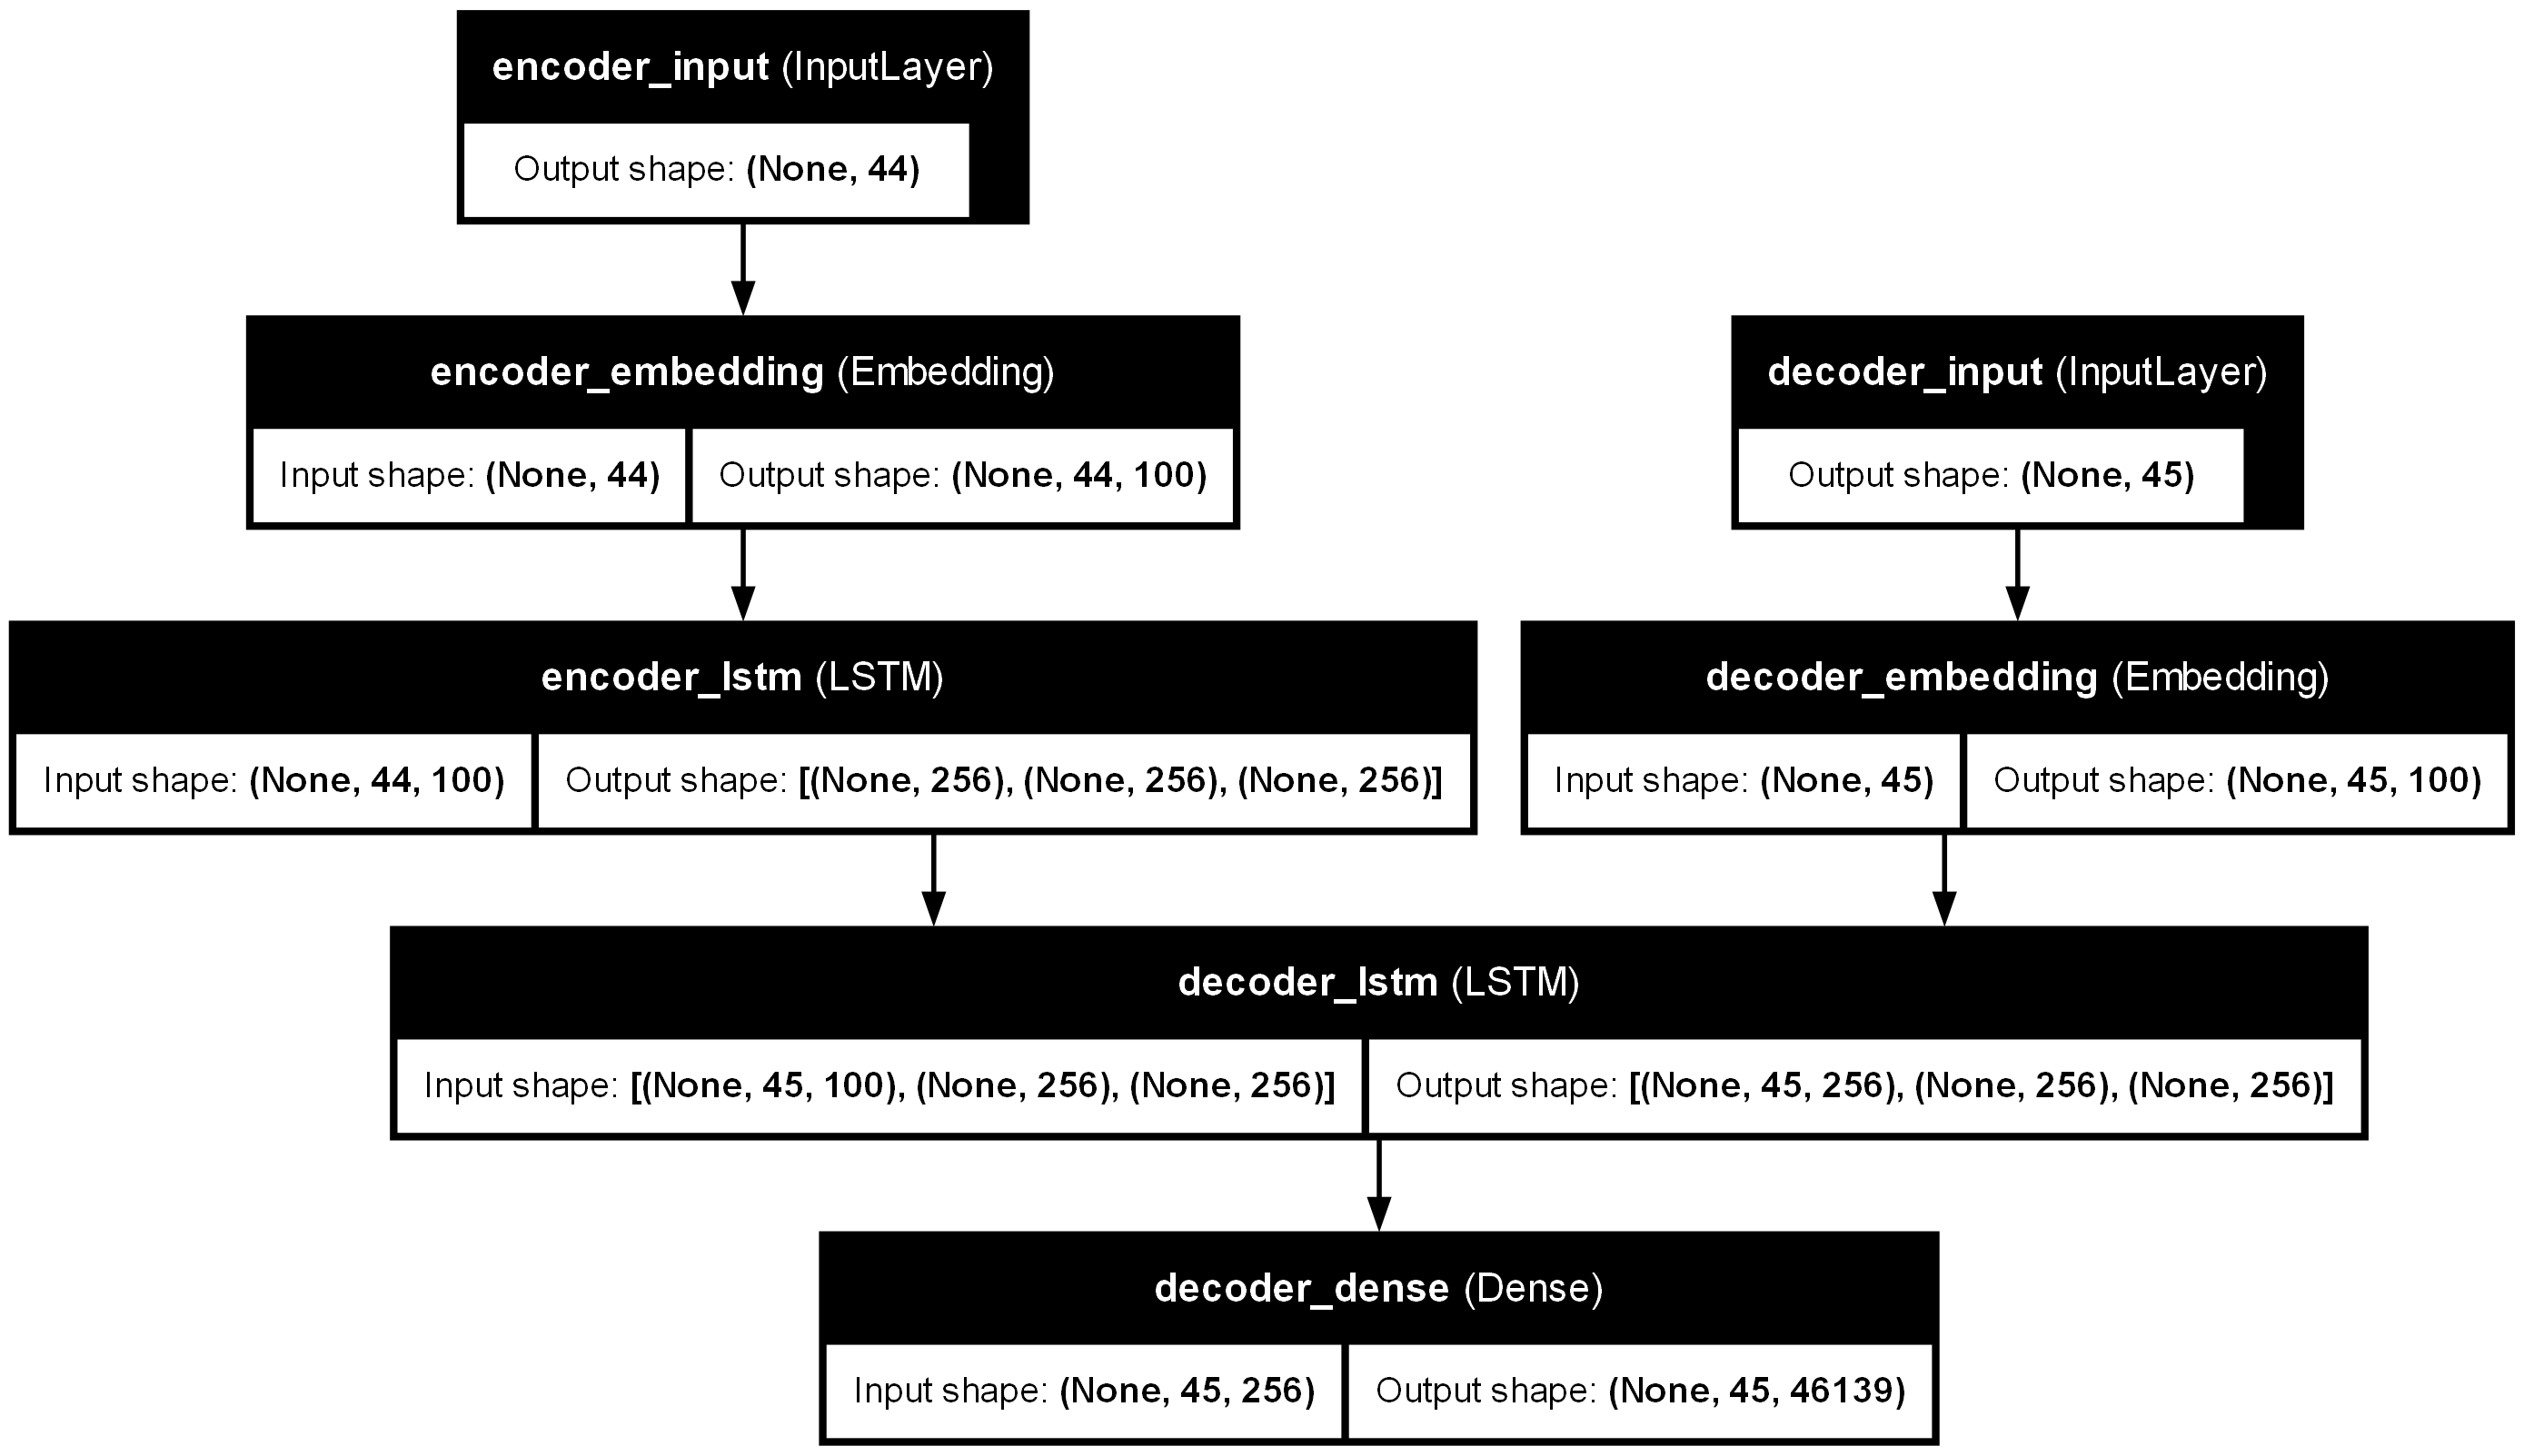

In [73]:
plot_model(model, to_file='plot/seq-to-seq-architecture-training.png', show_shapes=True, show_layer_names=True)

In [16]:
history = model.fit([train_eng_seq, train_pt_seq_input],  
                    train_pt_seq_target,  
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[callback])
model.save('models\seq2seq_translation_model_en_to_pt_glove.h5')


Epoch 1/5
  1/563 ━━━━━━━━━━━━━━━━━━━━ 7:11:16 46s/step - accuracy: 0.5096 - loss: 10.1928

### Loss and Accuracy plot

In [ ]:
# accuracy and loss plots
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, accuracy, '-', label='Training accuracy')
ax1.plot(epochs, val_accuracy, ':', label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper right')

ax2.plot(epochs, loss, '-', label='Training loss')
ax2.plot(epochs, val_loss, ':', label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

plt.show()

plt.savefig('plot/seq2seq_translation_model_en_to_pt_glove.png')

## Evaluate the model

### Inference Setup

In [112]:
# Encoder model
encoder_inputs = model.input[0]
encoder_embedding = model.layers[2](encoder_inputs)
encoder_lstm = model.layers[4]
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Define encoder states
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.load_weights('models\seq2seq_translation_model_en_to_pt_glove.h5')

# Decoder model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = model.layers[3](decoder_inputs_single)  

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, h, c = model.layers[5](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = model.layers[6](decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

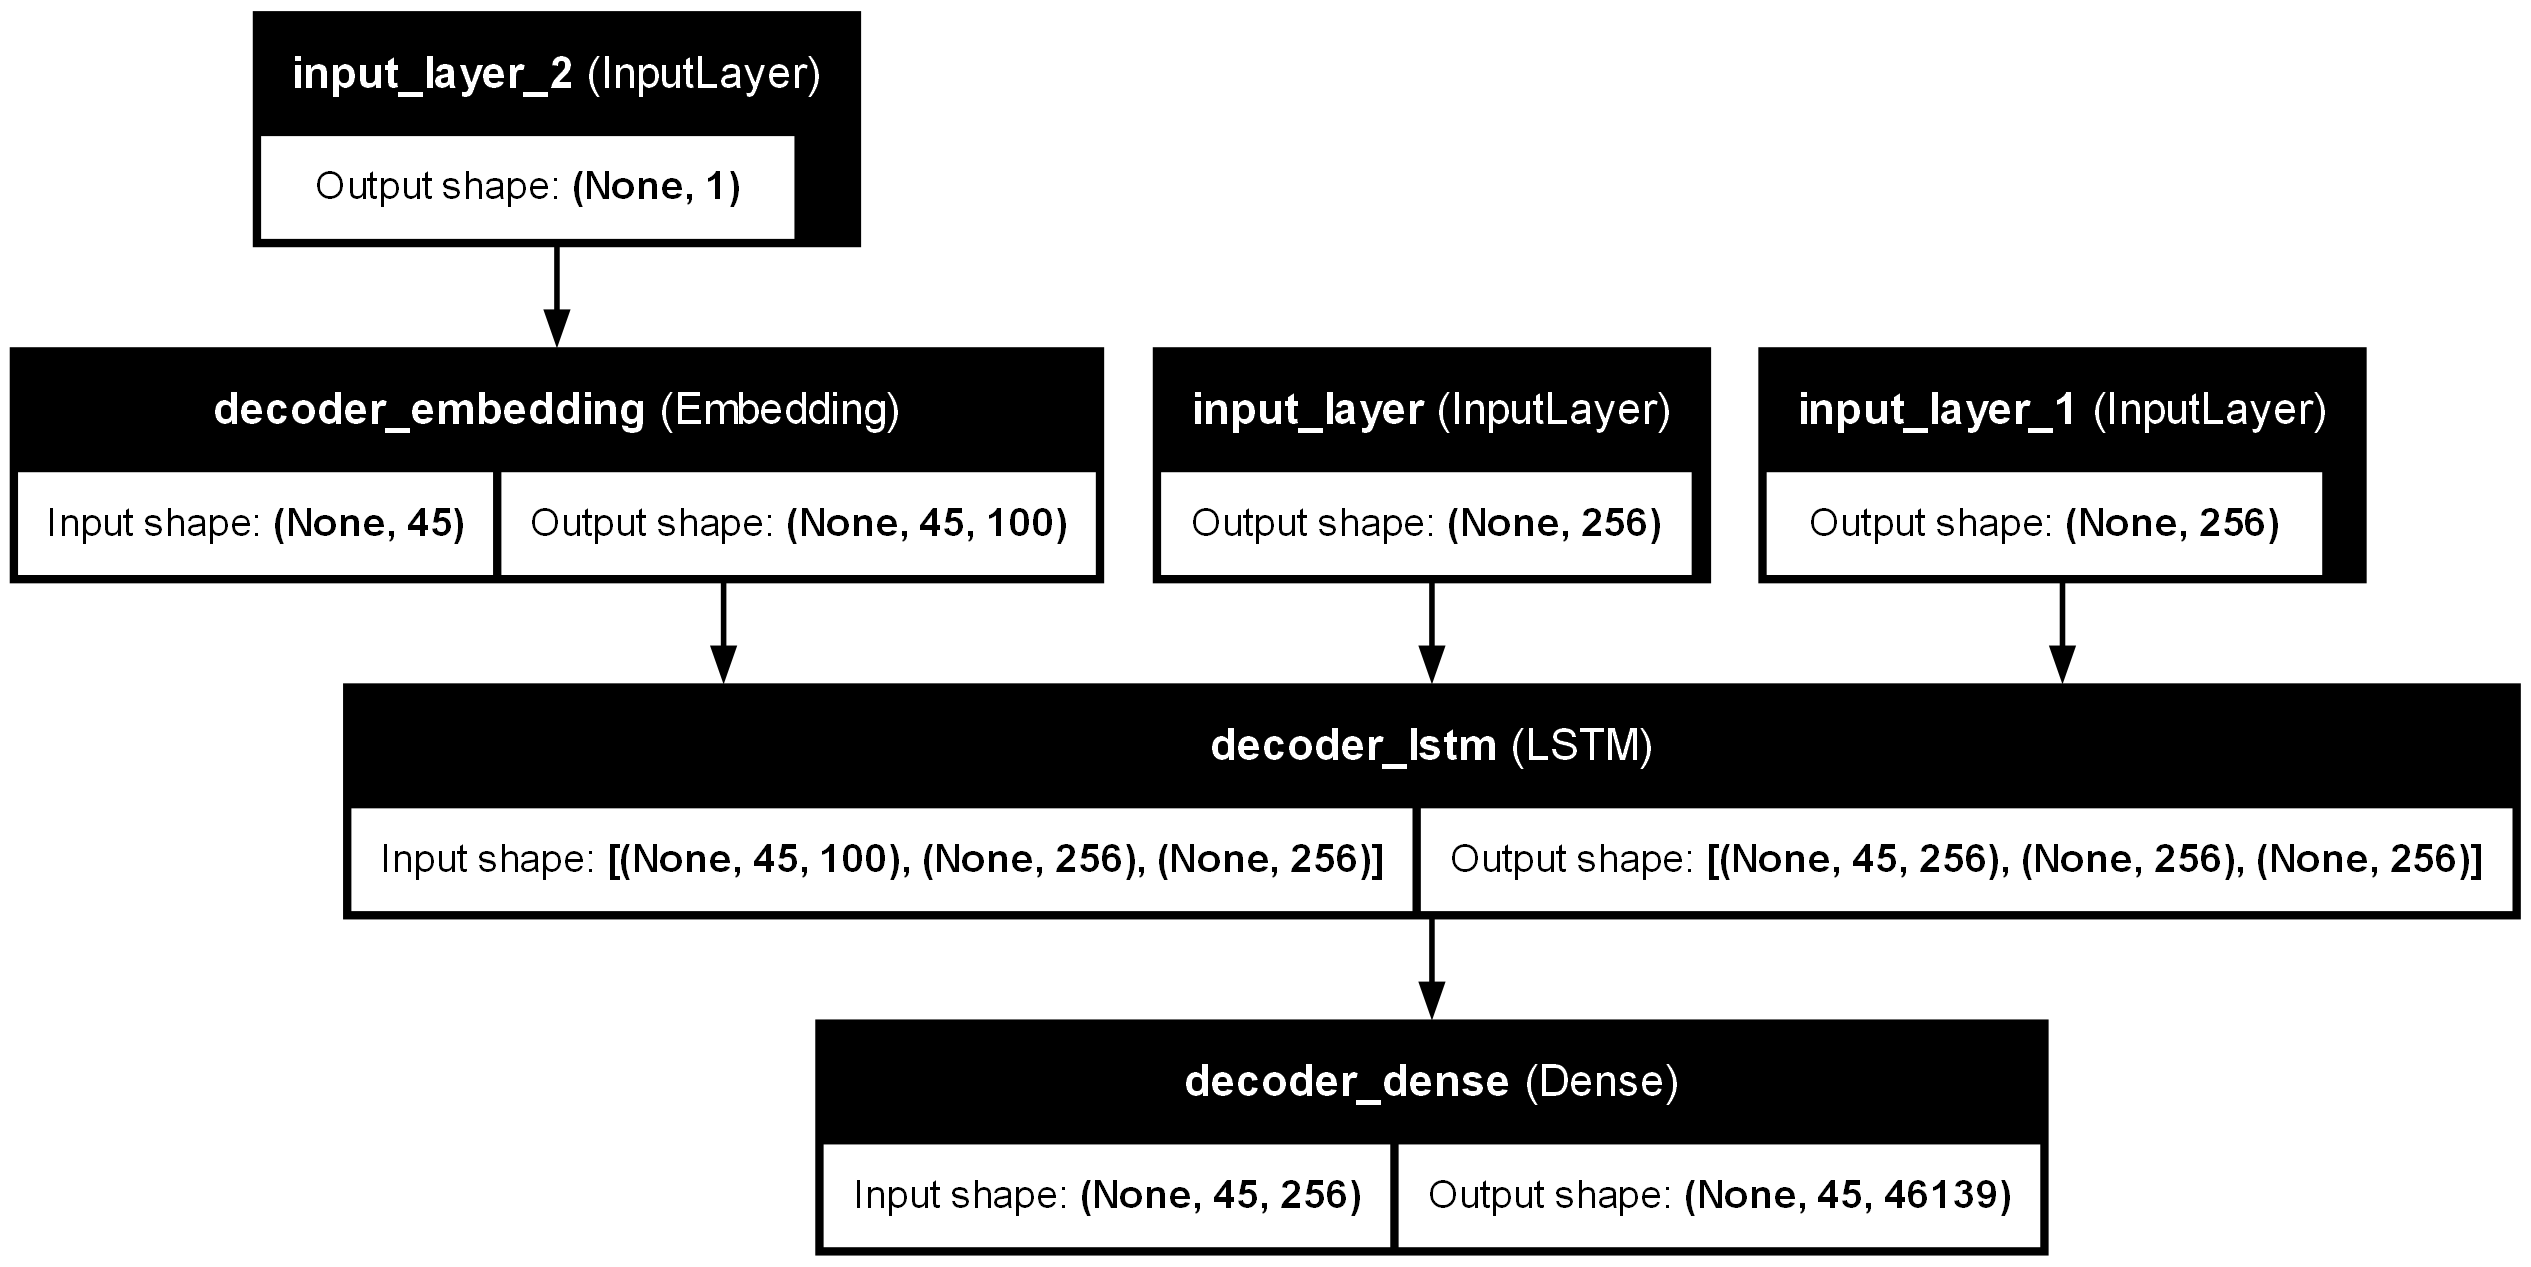

In [115]:
plot_model(decoder_model, to_file='plot/seq-to-seq-inference-setup.png', show_shapes=True, show_layer_names=True)

### Translate the sentences from the test data

In [ ]:

idx2word_target = {v:k for k, v in pt_tokenizer.word_index.items()} # index to word mapping for target language
word2idx_outputs = pt_tokenizer.word_index

evaluation_df = evaluation.translate_dataset(
    test_eng_seq,       # Test dataset as sequenced inputs
    test_eng,           # List of source sentences in English
    test_pt,            # List of reference translations in Portuguese
    encoder_model,      # Encoder model
    decoder_model,      # Decoder model
    idx2word_target,    # Index-to-word mapping for Portuguese
    pt_max_len,         # Maximum length of the target sequence
    word2idx_outputs,   # Word-to-index mapping for Portuguese
    save_interval=100,  # Save progress every 100 sentences
    save_path='translation_evaluation.csv'  # Path to save the file
)

# Display the first few rows of the DataFrame
print(evaluation_df.head())

#### Calculate BLEU and METEOR scores for the translated sentences

In [ ]:
evaluation_df = evaluation.calculate_scores(evaluation_df)
# Save and display results
evaluation_df.to_csv('translations/translation_evaluation_with_scores.csv', index=False)
print(evaluation_df.head())

### Compare Embedding Models

In [84]:
# Load the data
evaluation_glove = pd.read_csv('translations\\rnn_en_to_pt_glove_wordlevel.csv')
evaluation_word2vec = pd.read_csv('translations\\rnn_en_to_pt_word2vec_wordlevel.csv')
evaluation_fasttext = pd.read_csv('translations\\rnn_en_to_pt_fasttext_wordlevel.csv')

In [85]:

# Mittelwerte der BLEU Scores berechnen
avg_bleu_glove = evaluation_glove['BLEU Score'].mean()
avg_bleu_word2vec = evaluation_word2vec['BLEU Score'].mean()
avg_bleu_fasttext = evaluation_fasttext['BLEU Score'].mean()

print(f'Average BLEU Score for GloVe: {avg_bleu_glove}')
print(f'Average BLEU Score for Word2Vec: {avg_bleu_word2vec}')
print(f'Average BLEU Score for FastText: {avg_bleu_fasttext}')

Average BLEU Score for GloVe: 0.030148824443301782
Average BLEU Score for Word2Vec: 0.029366466081477596
Average BLEU Score for FastText: 0.02405803417961668


C:\Users\LUKE012\AppData\Local\Temp\ipykernel_12380\921823190.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  glove_avg_bleu = evaluation_glove.groupby('Binned Length')['BLEU Score'].mean().reset_index()
C:\Users\LUKE012\AppData\Local\Temp\ipykernel_12380\921823190.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word2vec_avg_bleu = evaluation_word2vec.groupby('Binned Length')['BLEU Score'].mean().reset_index()
C:\Users\LUKE012\AppData\Local\Temp\ipykernel_12380\921823190.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass 

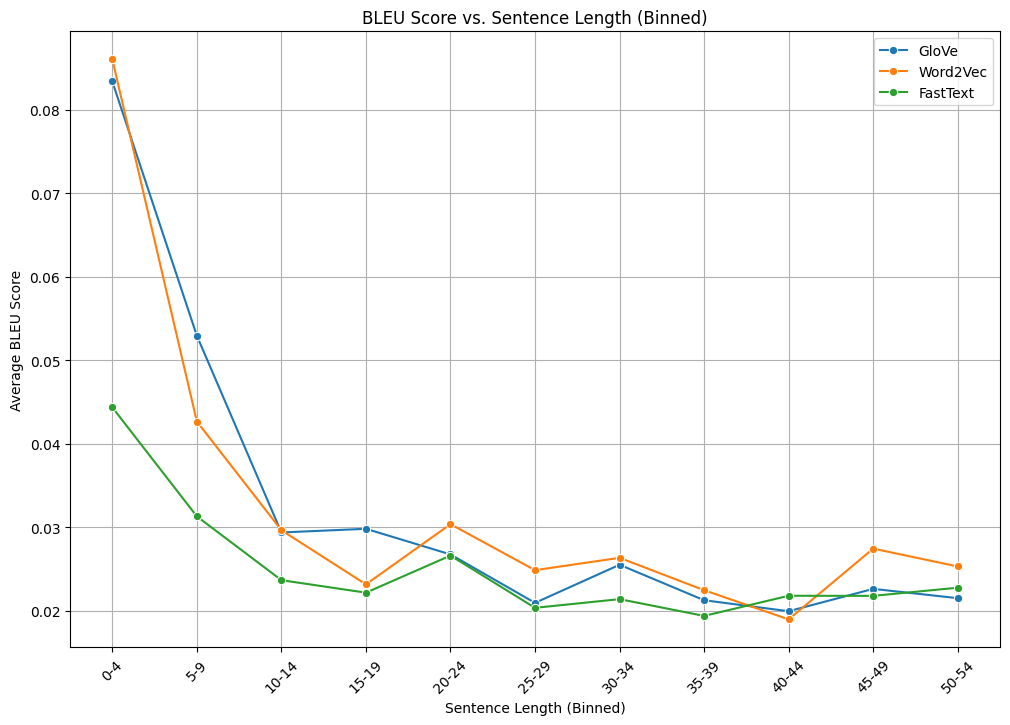

<Figure size 640x480 with 0 Axes>

In [82]:
### Plotting BLEU Score vs. Sentence Length

evaluation_glove['Sentence Length'] = evaluation_glove['Source Sentence'].apply(lambda x: len(str(x).split()))
evaluation_word2vec['Sentence Length'] = evaluation_word2vec['Source Sentence'].apply(lambda x: len(str(x).split()))
evaluation_fasttext['Sentence Length'] = evaluation_fasttext['Source Sentence'].apply(lambda x: len(str(x).split()))

bins = np.arange(0, 60, 5)  

evaluation_glove['Binned Length'] = pd.cut(evaluation_glove['Sentence Length'], bins)
evaluation_word2vec['Binned Length'] = pd.cut(evaluation_word2vec['Sentence Length'], bins)
evaluation_fasttext['Binned Length'] = pd.cut(evaluation_fasttext['Sentence Length'], bins)

glove_avg_bleu = evaluation_glove.groupby('Binned Length')['BLEU Score'].mean().reset_index()
word2vec_avg_bleu = evaluation_word2vec.groupby('Binned Length')['BLEU Score'].mean().reset_index()
fasttext_avg_bleu = evaluation_fasttext.groupby('Binned Length')['BLEU Score'].mean().reset_index()

glove_avg_bleu['Binned Length'] = glove_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")
word2vec_avg_bleu['Binned Length'] = word2vec_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")
fasttext_avg_bleu['Binned Length'] = fasttext_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")

plt.figure(figsize=(12, 8))
sns.lineplot(data=glove_avg_bleu, x='Binned Length', y='BLEU Score', label='GloVe', marker='o')
sns.lineplot(data=word2vec_avg_bleu, x='Binned Length', y='BLEU Score', label='Word2Vec', marker='o')
sns.lineplot(data=fasttext_avg_bleu, x='Binned Length', y='BLEU Score', label='FastText', marker='o')

plt.title('BLEU Score vs. Sentence Length (Binned)')
plt.xlabel('Sentence Length (Binned)')
plt.ylabel('Average BLEU Score')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

plt.savefig('plot/embedding_models_bleu_per_sentencelength.png')

In [99]:
### Statistics of BLEU Scores for Different Embeddings

glove_stats = evaluation_glove[['BLEU Score']].describe().drop(['min','count'])
word2vec_stats = evaluation_word2vec[['BLEU Score']].describe().drop(['min','count'])
fasttext_stats = evaluation_fasttext[['BLEU Score']].describe().drop(['min','count'])

combined_stats = pd.concat([
    glove_stats.rename(columns={'BLEU Score': 'GloVe'}),
    word2vec_stats.rename(columns={'BLEU Score': 'Word2Vec'}),
    fasttext_stats.rename(columns={'BLEU Score': 'FastText'})
], axis=1)

print("Statistics of BLEU Scores for Different Embeddings:")
print(combined_stats)



Statistics of BLEU Scores for Different Embeddings:
         GloVe  Word2Vec  FastText
mean  0.030149  0.029366  0.024058
std   0.056600  0.051831  0.030890
25%   0.011495  0.011274  0.010897
50%   0.017205  0.016296  0.015884
75%   0.028794  0.027776  0.025531
max   0.866878  0.866878  0.399388


In [143]:
### Most Frequent Predicted Words

def analyze_most_frequent_predicted_words(df, model_name):
    predicted_tokens = df['Model Translation'].str.split().explode()

    word_freq = Counter(predicted_tokens)

    top_words = word_freq.most_common(10)

    print(f"Top 10 most frequent predicted words ({model_name}):")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()


analyze_most_frequent_predicted_words(evaluation_glove, 'GloVe')
analyze_most_frequent_predicted_words(evaluation_word2vec, 'Word2Vec')
analyze_most_frequent_predicted_words(evaluation_fasttext, 'FastText')


Top 10 most frequent predicted words (GloVe):
a: 2162
de: 2070
que: 1652
e: 1311
se: 672
nao: 661
ser: 633
os: 615
um: 568
sua: 553

Top 10 most frequent predicted words (Word2Vec):
de: 2357
e: 1970
a: 1888
que: 1413
o: 830
nao: 739
se: 690
uma: 680
um: 446
os: 418

Top 10 most frequent predicted words (FastText):
a: 2676
e: 1994
de: 1946
que: 1565
se: 975
um: 894
o: 754
nao: 689
sua: 638
ser: 482



### Evaluate METEOR

In [152]:
glove_meteor_stats = evaluation_glove[['METEOR Score']].describe().drop(['min', 'count'])
word2vec_meteor_stats = evaluation_word2vec[['METEOR Score']].describe().drop(['min', 'count'])
fasttext_meteor_stats = evaluation_fasttext[['METEOR Score']].describe().drop(['min', 'count'])

combined_meteor_stats = pd.concat([
    glove_meteor_stats.rename(columns={'METEOR Score': 'GloVe METEOR'}),
    word2vec_meteor_stats.rename(columns={'METEOR Score': 'Word2Vec METEOR'}),
    fasttext_meteor_stats.rename(columns={'METEOR Score': 'FastText METEOR'})
], axis=1)

# Print METEOR statistics
print("\nStatistics of METEOR Scores for Different Embeddings:")
print(combined_meteor_stats)


Statistics of METEOR Scores for Different Embeddings:
      GloVe METEOR  Word2Vec METEOR  FastText METEOR
mean      0.147865         0.147305         0.134496
std       0.097056         0.095800         0.079121
25%       0.091870         0.091290         0.085974
50%       0.130435         0.131847         0.121951
75%       0.181297         0.181447         0.174383
max       0.976471         0.976471         0.613426


In [171]:
def top_scoring_sentences(df, metric, top_n=8):
    sorted_df = df.sort_values(by=metric, ascending=False)
    top_sentences = sorted_df.head(top_n)
    return top_sentences[['Source Sentence', 'Reference Translation', 'Model Translation', metric]]

# Get top scoring sentences for GloVe
top_glove_bleu = top_scoring_sentences(evaluation_glove, 'BLEU Score')
top_glove_meteor = top_scoring_sentences(evaluation_glove, 'METEOR Score')


def print_pretty_table(dataframe, title):
    print(f"\n{title}")
    print(tabulate(dataframe, headers='keys', tablefmt='pretty', showindex=False))

print_pretty_table(top_glove_bleu, "Top GloVe BLEU Scores")
print_pretty_table(top_glove_meteor, "Top GloVe METEOR Scores")



Top GloVe BLEU Scores
+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------+--------------------+
|                                                                  Source Sentence                                                                  |                                                                      Reference Translation                                                                      |                                                     Model Translation                                                      |     BLEU Score     |
+------------------------------------------------------------

## Translate Portuguese to English

### Reverse the initial setup

In [ ]:
train_decoder_inputs = ['<start> ' + text for text in train_eng]
test_decoder_inputs = ['<start> ' + text for text in test_eng]
train_decoder_targets = [text + ' <end>' for text in train_eng]
test_decoder_targets = [text + ' <end>' for text in test_eng]

#train tokenizer on training data
train_pt_seq, pt_tokenizer = preprocessing.tokenize(train_pt)  
train_eng_seq_input, eng_tokenizer = preprocessing.tokenize(train_decoder_inputs, decode=True)  
train_eng_seq_target,_ = preprocessing.tokenize(train_decoder_targets,tokenizer= eng_tokenizer)

#apply the tokenizer to the test and validation data
test_pt_seq,_ = preprocessing.tokenize(train_pt,tokenizer= pt_tokenizer)
test_eng_seq_input,_  = preprocessing.tokenize(test_decoder_inputs,tokenizer= eng_tokenizer)
test_eng_seq_target,_  = preprocessing.tokenize(test_decoder_targets, tokenizer= eng_tokenizer)


#apply padding to the sequences
train_pt_seq = preprocessing.pad(train_pt_seq,pt_max_len)
train_eng_seq_input = preprocessing.pad(test_eng_seq_input,en_max_len)
train_eng_seq_target  = preprocessing.pad(train_eng_seq_target,en_max_len)

test_pt_seq = preprocessing.pad(test_pt_seq, pt_max_len)
test_eng_seq_input = preprocessing.pad(test_eng_seq_input, en_max_len)
test_eng_seq_target  = preprocessing.pad(test_eng_seq_target, en_max_len)

en_vocab_size = len(eng_tokenizer.word_index)
pt_vocab_size = len(pt_tokenizer.word_index)

# GloVe embeddings
glove_embeddings_index = embedding_models.load_glove_embeddings(language="portuguese")
embedding_matrix_pt = embedding_models.apply_embedding_matrix(glove_embeddings_index, pt_tokenizer, embedding_dim=100)   #GloVe.6B.100d.txt has 100-dimensional embeddings 
glove_embeddings_index = embedding_models.load_glove_embeddings(language="english")
embedding_matrix_eng = embedding_models.apply_embedding_matrix(glove_embeddings_index, eng_tokenizer, embedding_dim=100) 

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model = create_model.create_seq2seq_wordlevel_model(
                             name = "seq2seq_translation_model_pt_to_en",
                             embedding_matrix_encoder=embedding_matrix_pt,
                             embedding_matrix_decoder=embedding_matrix_eng,
                             source_vocab_size=pt_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             target_vocab_size=en_vocab_size+1,# +1 for the PAD token which is assigned index 0
                             max_len_encoder=pt_max_len, 
                             max_len_decoder=en_max_len, 
                             embedding_dim=100,
                             latent_dim=256)  
# Compile the model  
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])  

history = model.fit([train_pt_seq, test_eng_seq_input],  
                    test_eng_seq_target,  
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[callback])
model.save('model/seq2seq_translation_model_pt_to_en_glove.h5')

### Compare results

In [7]:
evaluation_reverse = pd.read_csv('translations\\translation_reversed.csv')
evaluation_forward = pd.read_csv('translations\\rnn_en_to_pt_glove_wordlevel.csv')

In [28]:
forward_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev',  'METEOR 50%',  'METEOR Max'],
    'Forward': [
        evaluation_forward['BLEU Score'].mean(),
        evaluation_forward['BLEU Score'].std(),
        evaluation_forward['BLEU Score'].median(),
        evaluation_forward['BLEU Score'].max(),
        evaluation_forward['METEOR Score'].mean(),
        evaluation_forward['METEOR Score'].std(),
        evaluation_forward['METEOR Score'].median(),
        evaluation_forward['METEOR Score'].max()
    ]
}

reverse_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev', 'METEOR 50%', 'METEOR Max'],
    'Reverse': [
        evaluation_reverse['BLEU Score'].mean(),
        evaluation_reverse['BLEU Score'].std(),
        evaluation_reverse['BLEU Score'].median(),
        evaluation_reverse['BLEU Score'].max(),
        evaluation_reverse['METEOR Score'].mean(),
        evaluation_reverse['METEOR Score'].std(),
        evaluation_reverse['METEOR Score'].median(),
        evaluation_reverse['METEOR Score'].max()
    ]
}

forward_df = pd.DataFrame(forward_stats)
reverse_df = pd.DataFrame(reverse_stats)

comparison_df = pd.merge(forward_df, reverse_df, on='Metric')

print(tabulate(comparison_df, headers='keys', tablefmt='pretty'))


+---+----------------+----------------------+----------------------+
|   |     Metric     |       Forward        |       Reverse        |
+---+----------------+----------------------+----------------------+
| 0 |   BLEU Mean    | 0.030148824443301782 | 0.035549041317996063 |
| 1 |  BLEU Std Dev  | 0.056599808612902425 | 0.04859113183790444  |
| 2 |    BLEU 50%    | 0.017205105815435003 |  0.0202559860271256  |
| 3 |    BLEU Max    |  0.8668778997501817  |  0.5328009719875519  |
| 4 |  METEOR Mean   | 0.14786513368060805  | 0.18781221528538602  |
| 5 | METEOR Std Dev | 0.09705556931061933  | 0.10136390762945716  |
| 6 |   METEOR 50%   |  0.1304347826086956  |  0.1686211653163917  |
| 7 |   METEOR Max   |  0.9764705882352942  |  0.7942023541197095  |
+---+----------------+----------------------+----------------------+


In [30]:
# Get the top N sentences by BLEU score for both forward and reverse translations
N = 10  
top_forward_bleu = evaluation_forward.nlargest(N, 'BLEU Score')
top_reverse_bleu = evaluation_reverse.nlargest(N, 'BLEU Score')

forward_sentences = top_forward_bleu[['Source Sentence', 'Reference Translation', 'BLEU Score', 'METEOR Score']]
reverse_sentences = top_reverse_bleu[['Source Sentence', 'Reference Translation', 'BLEU Score', 'METEOR Score']]
reverse_sentences_renamed = reverse_sentences.rename(columns={
    'Source Sentence': 'Reference Translation',
    'Reference Translation': 'Source Sentence'
})
common_sentences = pd.merge(forward_sentences, reverse_sentences_renamed, on=['Source Sentence', 'Reference Translation'], suffixes=('_Forward', '_Reverse'))

print("Top Forward Sentences by BLEU Score:")
print(tabulate(forward_sentences, headers='keys', tablefmt='psql'))

print("\nTop Reverse Sentences by BLEU Score:")
print(tabulate(reverse_sentences, headers='keys', tablefmt='psql'))

print("\nCommon Sentences in Both Forward and Reverse by BLEU Score:")
print(tabulate(common_sentences, headers='keys', tablefmt='psql'))


Top Forward Sentences by BLEU Score:
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------+
|     | Source Sentence                                                                                                                                   | Reference Translation                                                                                                                                           |   BLEU Score |   METEOR Score |
|-----+---------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------